Комп'ютерний практикум 3

1. Реалізувати підпрограми із необхідними математичними операціями:
обчисленням оберненого елементу за модулем із використанням розширеного алгоритму
Евкліда, розв’язуванням лінійних порівнянь. При розв’язуванні порівнянь потрібно
коректно обробляти випадок із декількома розв’язками, повертаючи їх усі.


In [787]:
from collections import Counter
import itertools
import math

In [788]:
def extended_gcd(a, b):

    if b == 0:
        return (a, 1, 0)
    else:
        gcd, x1, y1 = extended_gcd(b, a % b)
        x = y1
        y = x1 - (a // b) * y1
        return (gcd, x, y)
    
def modular_inverse(a, m):

    gcd, x, _ = extended_gcd(a, m)
    if gcd != 1:
        return None 
    else:
        return x % m  

In [789]:
def solve_congruence(a_ceff, b_ceff, modulus):

    divisor, bezout_x, _ = extended_gcd(a_ceff, modulus)
    
    if b_ceff % divisor != 0:
        return []  
    
    yproshenoe_a = a_ceff // divisor
    yproshenoe_b = b_ceff // divisor
    yproshenoe_mod = modulus // divisor
    
    invrse_a = modular_inverse(yproshenoe_a, yproshenoe_mod)
    
    if invrse_a is None:
        return []  
    
    base_sol = (invrse_a * yproshenoe_b) % yproshenoe_mod
    
    solutions = []
    for i in range(divisor):
        solution = (base_sol + i * yproshenoe_mod) % modulus
        solutions.append(solution)
    
    return solutions


2. За допомогою програми обчислення частот біграм, яка написана в ході
виконання комп’ютерного практикуму №1, знайти 5 найчастіших біграм запропонованого
шифртексту

In [790]:
def compute_bigram_frequencies(text: str, step: int = 2) -> Counter:

    bigrams = []
    for i in range(0, len(text) - 1, step):
        bg = text[i:i+2]
        if len(bg) == 2:
            bigrams.append(bg)
    return Counter(bigrams)

def read_ciptext(path: str) -> str:

    with open(path, 'r', encoding='utf-8') as file:
        text = file.read()
        text = ''.join(filter(str.isalpha, text.lower()))
        return text

    
path = 'TEXT.txt'

ciphertext = read_ciptext(path)

chastota = compute_bigram_frequencies(ciphertext, step=2)

top_5 = [bg for bg, _ in chastota.most_common(5)]
print("Топ5 біграм :", top_5)


Топ5 біграм : ['тд', 'рб', 'во', 'щю', 'кд']


3. Перебрати можливі варіанти співставлення частих біграм мови та частих біграм
шифртексту (розглядаючи пари біграм із п’яти найчастіших). Для кожного співставлення
знайти можливі кандидати на ключ (a,b) шляхом розв’язання системи (1). 
4. Для кожного кандидата на ключ дешифрувати шифртекст. Якщо шифртекст не є
змістовним текстом російською мовою, відкинути цього кандидата.
5. Повторювати дії 3-4 доти, доки дешифрований текст не буде змістовним.


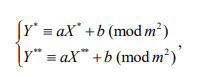

In [791]:
RUS_ALPHABET_31 = (
    "абвгдежзийклмнопрстуфхцчшщьыэюя"  
)

M = 31           
M_SQUARED = M*M  # m^2 =  961

COMMON_RUS_BIGRAMS = ["ст", "но", "то", "на", "ен"]

def char_to_idx(ch):

    try:
        return RUS_ALPHABET_31.index(ch)
    except ValueError:
        return None

def idx_to_char(idx):

    if 0 <= idx < len(RUS_ALPHABET_31):
        return RUS_ALPHABET_31[idx]
    return '?' 

def bigr_to_num(bigram): # X = x1 * m +x2 (x1,x2)

    if len(bigram) != 2:
        return None
    x1 = char_to_idx(bigram[0])
    x2 = char_to_idx(bigram[1])
    if x1 is None or x2 is None:
        return None
    return x1 * M + x2

def num_to_bigram(num): # y1 = Y // m, y2 = Y mod m, (y1,y2), Y (0 ... m^2-1)

    if not (0 <= num < M_SQUARED):
        return "??"
    y1 = num // M
    y2 = num % M
    return idx_to_char(y1) + idx_to_char(y2)

#       (x1, y1), (x2, y2) 
#       y1 = a*x1 + b (mod m)
#       y2 = a*x2 + b (mod m).

def solve_affine_bigram(x1, y1, x2, y2, modulus=M_SQUARED):

    # (y1 - y2) ≡ a*(x1 - x2) (mod m^2)

    diff_y = (y1 - y2) % modulus
    diff_x = (x1 - x2) % modulus

    g, _, _ = extended_gcd(diff_x, modulus)

    if diff_y % g != 0:
        return []

    d = g
    diff_x_prim = diff_x // d
    diff_y_prim = diff_y // d
    mod_prim = modulus // d

    inv_diff_x_prim = modular_inverse(diff_x_prim, mod_prim)
    if inv_diff_x_prim is None:
        return []

    a0 = (diff_y_prim * inv_diff_x_prim) % mod_prim

    solutions = []
    for k in range(d):
        a_candidate = (a0 + k * mod_prim) % modulus
        b_candidate = (y1 - a_candidate*x1) % modulus # b = y1 - a_candidate*x1 (mod m)
        solutions.append((a_candidate, b_candidate))

    return solutions


In [792]:
def decrypt_affine_bigram(ciphertext, a, b):

    plain = []
    for i in range(0, len(ciphertext) - 1, 2):
        bg = ciphertext[i:i+2]
        Y = bigram_to_num(bg)
        if Y is None:
            plain.append("??")
            continue

        g, _, _ = extended_gcd(a, M_SQUARED)
        if g != 1:
            return None
        inv_a = modular_inverse(a, M_SQUARED)
        if inv_a is None:
            return None

        X = (inv_a * ((Y - b) % M_SQUARED)) % M_SQUARED
        plain_bg = num_to_bigram(X)
        plain.append(plain_bg)
    return "".join(plain)

In [793]:
def is_russian_text(tixt, threshold_common=0.02, threshold_rare=0.005, entropy_threshold=4.4):

    # 1 Частота частих літер
    c_letters = ['о', 'а', 'е']
    c_common = sum(tixt.count(ch) for ch in c_letters)
    ratio = c_common / len(tixt)

    if ratio < threshold_common:
        return False

    # 2 Частота рідкісних літер
    rare_letters = ['ф', 'щ', 'ь']
    count_rare = sum(tixt.count(ch) for ch in rare_letters)
    ratio_rare = count_rare / len(tixt)

    if ratio_rare < threshold_rare:
        return False

    # 3 ентропія 
    entropy = calculate_entropy(tixt)
    if entropy > entropy_threshold:
        return False

    return True

def calculate_entropy(tixt):

    if not tixt:
        return 0.0
    freq = Counter(tixt)
    total = len(tixt)
    entropy = -sum((count / total) * math.log2(count / total) for count in freq.values())
    return entropy



In [794]:
common_pairs = list(itertools.combinations(COMMON_RUS_BIGRAMS, 2))
cipher_pairs = list(itertools.combinations(top_5, 2))

for (bg_rus_1, bg_rus_2) in common_pairs:
    x1 = bigr_to_num(bg_rus_1)
    x2 = bigr_to_num(bg_rus_2)

    for (bg_ciph_1, bg_ciph_2) in cipher_pairs:
        y1 = bigr_to_num(bg_ciph_1)
        y2 = bigr_to_num(bg_ciph_2)

        candidates = solve_affine_bigram(x1, y1, x2, y2, modulus=M_SQUARED)
        if not candidates:
            continue

        for (a_candidate, b_candidate) in candidates:
            decrypted_text = decrypt_affine_bigram(ciphertext, a_candidate, b_candidate)
            if not decrypted_text:
                continue  

            if is_russian_text(decrypted_text):
                print(" ключ (a, b) =", (candidates))
                print(decrypted_text)


 ключ (a, b) = [(199, 700)]
отцеубийствокакизвестноосновноеиизначальноепреступлениечеловечестваиотдельногочеловекавовсякомслучаеоноглавныйисточникчувствавинынеизвестноединственныйлиисследованиямнеудалосьещеустановитьдушевноепроисхождениевиныипотребностиискупленияноотнюдьнесущественноединственныйлиэтоисточникпсихологическоеположениесложноинуждаетсявобясненияхотношениемальчикакотцукакмыговоримамбивалентнопомимоненавистииззакоторойхотелосьбыотцакаксоперникаустранитьсуществуетобычнонекотораядолянежностикнемуобаотношениясливаютсявидентификациюсотцомхотелосьбызанятьместоотцапотомучтоонвызываетвосхищениехотелосьбыбытькаконипотомучтохочетсяегоустранитьвсеэтонаталкиваетсянакрупноепрепятствиевопределенныймоментребенокначинаетпониматьчтопопыткаустранитьотцакаксоперникавстретилабысостороныотцанаказаниечерезкастрациюизстрахакастрациитоестьвинтересахсохранениясвоеймужественностиребенокотказываетсяотжеланияобладатьматерьюиотустраненияотцапосколькуэтожеланиеостаетсявобластибессознательногооноявляетсяо